In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression,LassoCV,Lasso
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [3]:
# load Data

data = pd.read_csv('rental_info.csv')

data.info()
data.head()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15861 entries, 0 to 15860
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   rental_date       15861 non-null  object 
 1   return_date       15861 non-null  object 
 2   amount            15861 non-null  float64
 3   release_year      15861 non-null  float64
 4   rental_rate       15861 non-null  float64
 5   length            15861 non-null  float64
 6   replacement_cost  15861 non-null  float64
 7   special_features  15861 non-null  object 
 8   NC-17             15861 non-null  int64  
 9   PG                15861 non-null  int64  
 10  PG-13             15861 non-null  int64  
 11  R                 15861 non-null  int64  
 12  amount_2          15861 non-null  float64
 13  length_2          15861 non-null  float64
 14  rental_rate_2     15861 non-null  float64
dtypes: float64(8), int64(4), object(3)
memory usage: 1.8+ MB


,rental_date,return_date,amount,release_year,rental_rate,length,replacement_cost,special_features,NC-17,PG,PG-13,R,amount_2,length_2,rental_rate_2
0,2005-05-25 02:54:33+00:00,2005-05-28 23:40:33+00:00,2.99,2005.0,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401
1,2005-06-15 23:19:16+00:00,2005-06-18 19:24:16+00:00,2.99,2005.0,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401
2,2005-07-10 04:27:45+00:00,2005-07-17 10:11:45+00:00,2.99,2005.0,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401
3,2005-07-31 12:06:41+00:00,2005-08-02 14:30:41+00:00,2.99,2005.0,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401
4,2005-08-19 12:30:04+00:00,2005-08-23 13:35:04+00:00,2.99,2005.0,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401


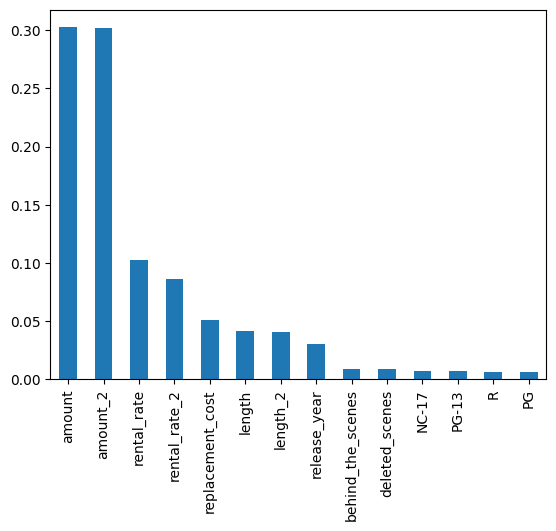

In [14]:
# Preprocessing

data['rental_date'] = pd.to_datetime(data['rental_date'])
data['return_date'] = pd.to_datetime(data['return_date'])

# Calculate rental duration in days
data['rental_length_days'] = (data['return_date'] - data['rental_date']).dt.days



# convert to dummy
data['deleted_scenes']=np.where(data['special_features'].str.contains('Deleted Scenes'),1,0)
data['behind_the_scenes']=np.where(data['special_features'].str.contains('Behind the Scenes'),1,0)

# selected features
X = data.drop(columns='rental_length_days')
y = data['rental_length_days']

model = RandomForestRegressor()
numeric_X = X.select_dtypes(include=['float64', 'int64'])
model.fit(numeric_X, y)

importances = pd.Series(model.feature_importances_, index=numeric_X.columns)
importances.sort_values(ascending=False).plot(kind='bar')
plt.show()

best_4_features=['amount_2','amount','rental_rate_2','rental_rate']
new_X=data[best_4_features]
new_y=data['rental_length_days']

# splitting data

X_train,X_test,y_train,y_test=train_test_split(new_X, new_y,stratify=new_y, test_size=0.2, random_state=9)

In [30]:
# find best model


# 1-Linear Regression model
logreg=LinearRegression()
logreg.fit(X_train,y_train)
logerg_y_pred=logreg.predict(X_test)
logreg_mse = mean_squared_error(logerg_y_pred,y_test)
print(logreg_mse)


# 2-lasso model
alphas = np.logspace(-4, 1, 50)
model = LassoCV(alphas=alphas, cv=5)
model.fit(X_train, y_train)
best_alpha=model.alpha_

lasso=Lasso(alpha=best_alpha)
lasso.fit(X_train,y_train)
lasso_y_pred=lasso.predict(X_test)
lasso_mse = mean_squared_error(lasso_y_pred,y_test)
print(lasso_mse)

# 3-Random Forest model
rf=RandomForestRegressor(random_state=11)
params = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [None, 10, 20, 30, 50],
    'min_samples_leaf': [1, 2, 4, 8, 16, 32],
    'min_samples_split': [2, 5, 10] 
}
rf_randomizedsearch=RandomizedSearchCV(estimator=rf,param_distributions=params, n_iter=10, cv=5, verbose=1, n_jobs=-1, scoring='neg_mean_squared_error', random_state=42)

rf_randomizedsearch.fit(X_train, y_train)
best_rf = rf_randomizedsearch.best_estimator_
rf_y_pred=best_rf.predict(X_test)
rf_mse=mean_squared_error(rf_y_pred,y_test)
print(rf_mse)

best_model=lasso
best_mse=lasso_mse


2.8846066422881953
2.8846408046513363
Fitting 5 folds for each of 10 candidates, totalling 50 fits
2.412428753022222
